In [1]:
import numpy as np
import pandas as pd
import glob
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
import imageio
import skimage

In [2]:
path1 = 'posters/' #path where all posters are stored (images)
data = pd.read_csv("H:\ML Projects\MovieGenre.csv", encoding="ISO-8859-1")

In [3]:
data.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


In [ ]:
#This will download all posters in the posters folder
import urllib.request

def dl_img(url,path,name):
    full_path = path+name+'.jpg'
    try:
        urllib.request.urlretrieve(url,full_path)
    except:
        print('file not available')
        
for i in range(len(data['Poster'])):
    url = data['Poster'].iloc[i]
    filename = str(data['imdbId'].iloc[i])
    dl_img(url,path1,filename)


file not available


In [4]:
image_glob = glob.glob(path1 + "/" + "*.jpg")
img_dict = {}

def get_id(filename):
    index_s = filename.rfind("s") + 2
    index_f = filename.rfind(".jpg")
    return filename[index_s:index_f]

In [5]:
for fn in image_glob:
    try:
        img_dict[get_id(fn)] = imageio.imread(fn)
    except:
        pass

In [6]:
def show_img(id):
    title = data[data["imdbId"] == int(id)]["Title"].values[0]
    genre = data[data["imdbId"] == int(id)]["Genre"].values[0]
    plt.imshow(img_dict[id])
    plt.title("{} \n {}".format(title, genre))

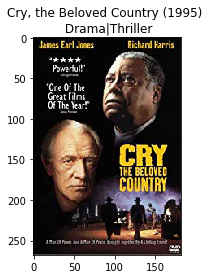

In [7]:
show_img("112749")

In [8]:
def preprocess(img, size=(150, 101)):
    #img = scipy.misc.imresize(img, size)
    img = skimage.transform.resize(img, size)
    img = img.astype(np.float32)
    img = (img / 127.5) - 1.
    return img

In [9]:
def prepare_data(data, img_dict, size=(150, 101)):
    print("Generation dataset...")
    dataset = []
    y = []
    ids = []
    label_dict = {"word2idx": {}, "idx2word": []}
    idx = 0
    genre_per_movie = data["Genre"].apply(lambda x: str(x).split("|"))
    for l in [g for d in genre_per_movie for g in d]:
        if l in label_dict["idx2word"]:
            pass
        else:
            label_dict["idx2word"].append(l)
            label_dict["word2idx"][l] = idx
            idx += 1
    n_classes = len(label_dict["idx2word"])
    print("identified {} classes".format(n_classes))
    n_samples = len(img_dict)
    print("got {} samples".format(n_samples))
    for k in img_dict:
        try:
            g = data[data["imdbId"] == int(k)]["Genre"].values[0].split("|")
            img = preprocess(img_dict[k], size)
            if img.shape != (150, 101, 3):
                continue
            l = np.sum([np.eye(n_classes, dtype="uint8")[label_dict["word2idx"][s]] 
                                                        for s in g], axis=0)
            y.append(l)
            dataset.append(img)
            ids.append(k)
        except:
            print('error')
    print("DONE")
    return dataset, y, label_dict, ids

In [10]:
SIZE = (150, 101)
dataset, y, label_dict, ids =  prepare_data(data, img_dict, size=SIZE)

Generation dataset...
identified 29 classes
got 12897 samples


C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


error
error
error
error
error
error
error
DONE


In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

Using TensorFlow backend.


In [3]:
SIZE = (150, 101)

In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                 input_shape=(SIZE[0], SIZE[1], 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(29, activation='sigmoid'))

W1030 12:11:18.304309 13380 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1030 12:11:18.326250 13380 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1030 12:11:18.330240 13380 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1030 12:11:18.371133 13380 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1030 12:11:18.376119 13380 deprecation_wrapper.py:119] From C:\ProgramData\Ana

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

W1030 12:11:33.536598 13380 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1030 12:11:33.542584 13380 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W1030 12:11:33.548565 13380 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
import pickle
with open('train.pickle', 'wb') as f:
    pickle.dump([dataset, y], f)


In [16]:
n = 10000
model.fit(np.array(dataset[: n]), np.array(y[: n]), batch_size=16, epochs=5,
          verbose=1, validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/5
9000/9000 [==============================] - 442s 49ms/step - loss: 0.2441 - acc: 0.9150 - val_loss: 0.2176 - val_acc: 0.9238
Epoch 2/5
9000/9000 [==============================] - 436s 48ms/step - loss: 0.2189 - acc: 0.9231 - val_loss: 0.2163 - val_acc: 0.9238
Epoch 3/5
9000/9000 [==============================] - 436s 48ms/step - loss: 0.2158 - acc: 0.9240 - val_loss: 0.2193 - val_acc: 0.9238
Epoch 4/5
9000/9000 [==============================] - 433s 48ms/step - loss: 0.2145 - acc: 0.9242 - val_loss: 0.2168 - val_acc: 0.9238
Epoch 5/5
9000/9000 [==============================] - 438s 49ms/step - loss: 0.2136 - acc: 0.9243 - val_loss: 0.2155 - val_acc: 0.9238


In [17]:
n = 10000

In [18]:
from keras.models import load_model
model=load_model("movie.h5")

In [19]:
n_test = 100
X_test = dataset[n:n + n_test]
y_test = y[n:n + n_test]

In [20]:
pred = model.predict(np.array(X_test))

In [21]:
def show_example(idx):
    N_true = int(np.sum(y_test[idx]))
    show_img(ids[n + idx])
    print("Prediction: {}".format("|".join(["{} ({:.3})".format(label_dict["idx2word"][s],
                                                                pred[idx][s])
                                            for s in pred[idx].argsort()[-N_true:][::-1]])))

Prediction: Drama (0.574)


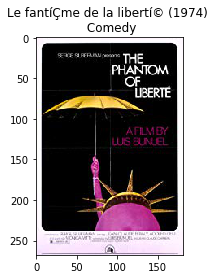

In [23]:
show_example(9)